In [38]:
#Importing openCv both as cv2 and cv for better convinence 
import cv2  
import cv2 as cv 
# Importing numpy for working with numpy arrays
import numpy as np 

# Importing pyplot as plt from maplotlib for Image Visualization
from matplotlib import pyplot as plt 

#Importing PIL library for working with Images
from PIL import Image 

#Importing asarray method from numpy for dealing with pixels of Images
from numpy import asarray 

import matplotlib.image as mpimg

#Importing ndimage from scipy as this package contains various functions for multidimensional image processing.
from scipy import ndimage

#Importing filters, features, measures and color from skimage
from skimage import filters, feature, measure, color

In [39]:
def show(image,x=30,y=10):
  img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(x,y))
  plt.imshow(img)


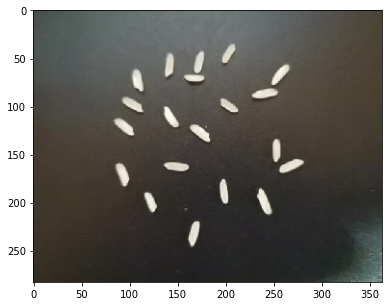

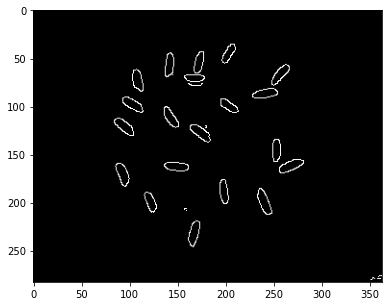

In [40]:

img = cv.imread('samp.PNG')
gray = cv.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gaussian = cv.GaussianBlur(gray,(3,3),0)

#canny
img_canny = cv.Canny(img,100,200)


show(img,25,5)
show(img_canny,25,5)



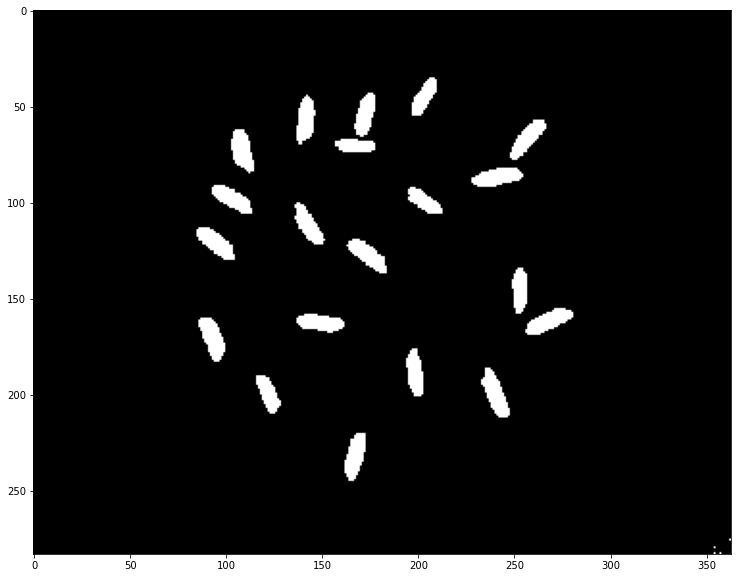

In [41]:
#Copying the preprocessed image as label_image
#Converting Image BGR Image to Gray for Image thresholding and further Image-Preprocessing application
grayscale_Image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh_img = cv2.threshold(grayscale_Image, 150, 255, cv2.THRESH_BINARY)

#Using show function earlier defined
show(thresh_img)

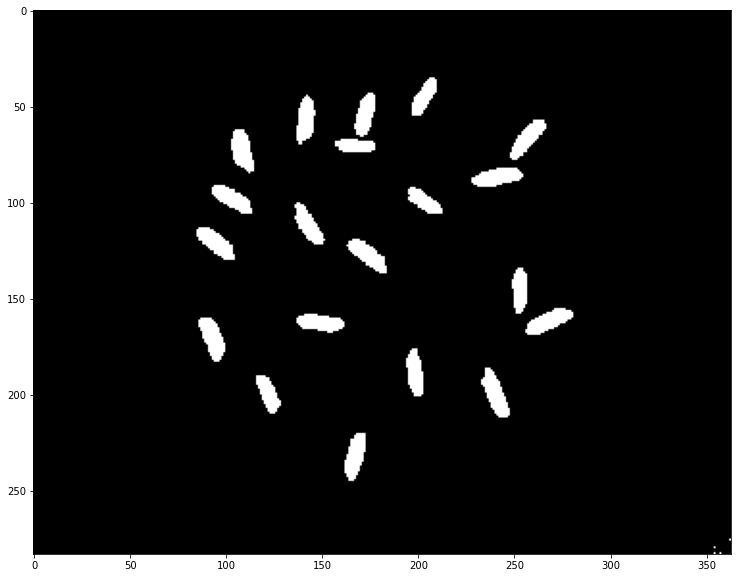

In [42]:
# Noise removal
kernel = np.ones((1),np.uint8)
clear_image = cv2.morphologyEx(thresh_img,cv2.MORPH_OPEN, kernel, iterations=8)
cv2.imwrite('img/img_clear.PNG',clear_image)
#Using show function earlier defined
show(clear_image)

Number of foreground objects 24


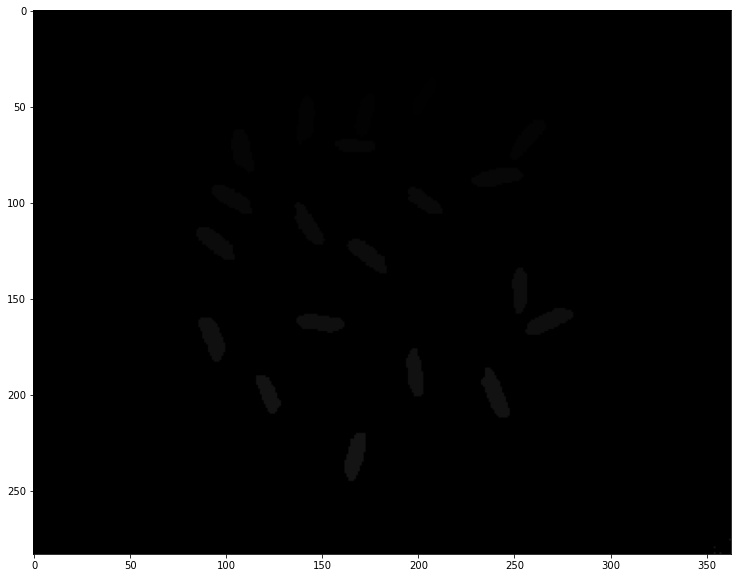

In [43]:
#Copying the preprocessed image as label_image
label_image = clear_image

#Creating a label_count variable to the count the number of grains in the image
label_count = 0

#Shape function for getting height and width
rows, cols = label_image.shape

#Looping through the pixel of image using rows and column of image
for j in range(rows):
    for i in range(cols):
        pixel = label_image[j, i]

        #Here there is single channel with 2 pixel intensities, Either 0 or 255. 0 represent black portion, where 255 represent grains (White).
        #Counting the total number of pixel with intensity 255
        if 255 == pixel:
            label_count += 1

            ##Applying floodFill method of opencv which will help in filling the backgroud that will ultimately helps in couting the contoured grain easily
            cv.floodFill(label_image, None, (i, j), label_count)

     


print("Number of foreground objects", label_count)
show(label_image)

Number of detected contours 24


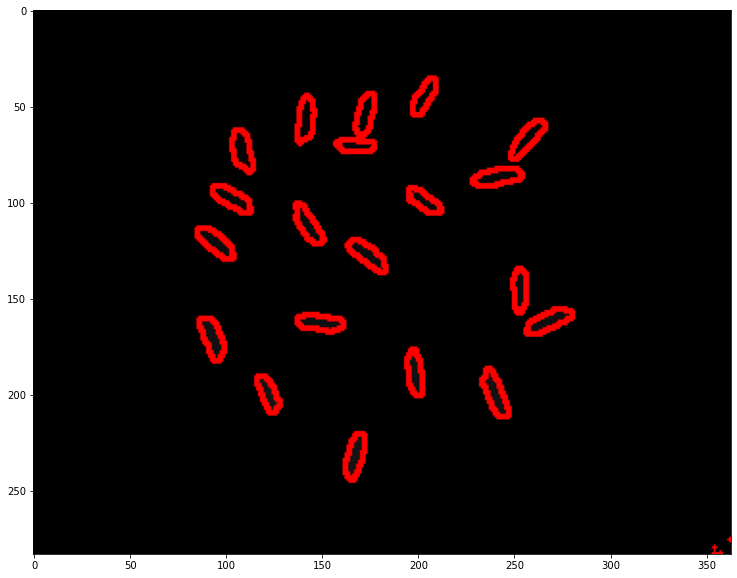

In [44]:
#Applying Countours method to get the count of rice grains
contours, hierarchy = cv.findContours(clear_image, 
                                      cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)


output_contour = cv.cvtColor(clear_image, cv.COLOR_GRAY2BGR)
cv.drawContours(output_contour, contours, -1, (0, 0, 255), 2)
print("Number of detected contours", len(contours))


show(output_contour)




In [45]:
import pandas as pd
clusters = measure.regionprops(clear_image, img)
pixels_to_um = 0.2645833333 # (1 px = 0.2645833333 mm)

propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']    

output_file = open('image_measurements.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n') #join strings in array by commas, leave first cell blank
#First cell blank to leave room for header (column names)

for cluster_props in clusters:
    #output cluster properties to the excel file
    output_file.write(str(cluster_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = cluster_props[prop]*pixels_to_um**2   #Convert pixel square to mm square
        elif(prop == 'orientation'): 
            to_print = cluster_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = cluster_props[prop]*pixels_to_um
        else: 
            to_print = cluster_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')
output_file.close()   #Closes the file, otherwise it would be read only. 

In [46]:
def classification_length (length):
	length =round(length,1)
	toret=""
	if(length >= 9.9):
		toret="extra long"
	elif(length >= 8.8 and length< 9.8):
		toret="long"
	elif(length >= 8.0 and length < 8.7):
		toret="medium"
	elif(length < 8 ):
		toret="short"
	toret=""+toret+""
	return toret

def classification_scale (scale):
	scale =round(scale,1)
	torat=""
	if(scale >= 3):
		torat="slender"
	elif(scale >= 2.1 and scale < 3):
		torat="medium"
	elif(scale >= 1.1 and scale < 2):
		torat="bold"
	elif(scale < 1.1 ):
		torat="round"
	torat=""+torat+""
	return torat

def lengthcategory(row):
   return classification_length(row[4])
def scalecategory(row1):
   return classification_scale(row1[10])



df = pd.read_csv('image_measurements.csv')
length = df["MajorAxisLength"]
width = df["MinorAxisLength"]
df["Scale"] = length.div(width.values)
df["Category"] = df.apply(lengthcategory, axis=1)
df["Shape"] = df.apply(scalecategory, axis=1)

In [47]:
newdf = round(df[["Area", "MajorAxisLength","Category", "MinorAxisLength", "Scale", "Shape"]], 2)
df.index = np.arange(1, len(df) + 1)
cv2.imwrite('img/img_canny.PNG',img_canny)
cv2.imwrite('img/img_thresh.PNG',thresh_img)
cv2.imwrite('img/img_label.PNG',label_image)
cv2.imwrite('img/img_contours.PNG',output_contour)
cv2.imwrite('img/img_boundrect.PNG',img)
df2=newdf.dropna()
df2 = df2.reset_index(drop=True)
df2.index = np.arange(1, len(df2) + 1)
df2.columns.values[0:6] =["Area", "Length","Category", "Width", "Scale", "Shape"]
df2.to_csv('result.csv')
df2

,Area,Length,Category,Width,Scale,Shape
1,10.29,6.16,short,2.15,2.87,medium
2,11.76,6.44,short,2.34,2.75,medium
3,12.53,6.78,short,2.40,2.82,medium
4,12.88,7.20,short,2.32,3.10,slender
5,13.16,6.27,short,2.75,2.28,medium
6,8.68,5.88,short,1.90,3.10,slender
7,13.51,7.32,short,2.37,3.09,slender
8,12.32,6.56,short,2.42,2.72,medium
9,9.80,5.77,short,2.21,2.61,medium
10,12.18,6.74,short,2.37,2.84,medium


In [48]:
df3 = df2["Scale"].mean()
df4 = df2["MajorAxisLength"].mean()
df5 = len(df2.axes[0])
checkxtra = 'extra long' in df2['Category'].unique()
checklong = 'long' in df2['Category'].unique()
checkmedium = 'medium' in df2['Category'].unique()
checkshort = 'short' in df2['Category'].unique()
strxlongcount = '0'
strlongcount = '0'
strmediumcount = '0'
strshortcount = '0'
if checkxtra == True:
    xtralongcount = df2['Category'].value_counts()['extra long']
    strxlongcount = str(xtralongcount)
    if xtralongcount > 0:
        print("Number of extra long: ", xtralongcount)
if checklong == True:
    longcount = df2['Category'].value_counts()['long']
    strlongcount = str(longcount)
    if longcount > 0:
        print("Number of long : ", longcount)
if checkmedium == True:
    mediumcount = df2['Category'].value_counts()['medium']
    strmediumcount = str(mediumcount)
    if mediumcount >0:
        print("Number of medium: ", mediumcount)
if checkshort == True:
    shortcount = df2['Category'].value_counts()['short']
    strshortcount = str(mediumcount)
    if shortcount > 0:
        print("Number of short: ", shortcount)
print("Ave. ratio of grains is ", round(df3,2), classification_scale(df3))
print("Ave. Length of grains is ", round(df4,2), classification_length(df4))
print('Row count without NaN value is :', df5)





Number of short:  20
Ave. ratio of grains is  2.85 medium
Ave. Length of grains is  6.67 short
Row count without NaN value is : 20


In [49]:
#Sending data to the database
import MySQLdb
strdf3 = str(round(df3,2))
strdf4 = str(round(df4,2))
strdf5 = str(df5)

inlength = strdf3
inratio = strdf4
incount = strdf5
incategory = classification_length(df4)
inshape = classification_scale(df3)
db=MySQLdb.connect("localhost", "root", "", "db_thesis")
insertrec=db.cursor()
sql = "DELETE FROM result_table"
insertrec.execute(sql)
sqlquery="insert into result_table(avelength, averatio, graincount, shape, category, short, medium, slong, extra_long) values ('"+inlength+"', '"+inratio+"', '"+incount+"', '"+inshape+"', '"+incategory+"', '"+strshortcount+"', '"+strmediumcount+"', '"+strlongcount+"', '"+strxlongcount+"')"
insertrec.execute(sqlquery)
db.commit()
print("Record Saved")
db.close()


Record Saved
